In [2]:
import pandas as pd

In [8]:
import easycolab as ec
ec.mount()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive
Opening directory /content/gdrive/My Drive/
Done!
Mounted at /content/drive


In [11]:
df = pd.read_csv('/content/drive/MyDrive/GlobalTempClean.csv')

In [12]:
import numpy as np

In [13]:
df.head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year
0,0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743
1,5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,1744
2,6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,1744
3,7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,1744
4,8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,1744


In [14]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt')

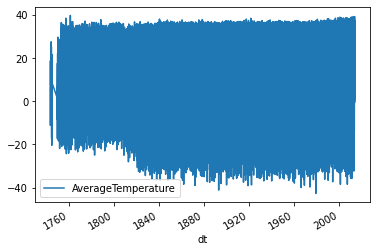

In [15]:
import matplotlib.pyplot as plt

df[['AverageTemperature']].plot() 
plt.show()

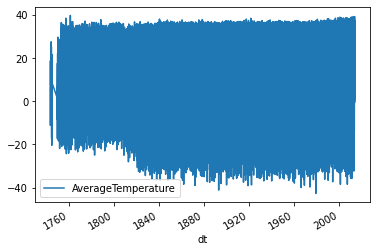

In [16]:
data_inter = df.interpolate()
data_inter[['AverageTemperature']].plot()
plt.show()

In [17]:
data = data_inter['AverageTemperature'].values
print(data.shape)

from sklearn.preprocessing import MinMaxScaler

data = data.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)
scaled_data_series = scaled_data.reshape(1,-1)
print(scaled_data_series)

(8235082,)
[[0.59221662]
 [0.58881671]
 [0.64778095]
 ...
 [0.70119604]
 [0.74651205]
 [0.73740514]]
[[0.59221662 0.58881671 0.64778095 ... 0.70119604 0.74651205 0.73740514]]


In [18]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [19]:
raw_seq = scaled_data_series[0]
n_steps = 12

# split into samples
X, y = split_sequence(raw_seq, n_steps)

In [20]:
print(X.shape)
print(X[1])

(8235070, 12)
[0.58881671 0.64778095 0.68915063 0.71381215 0.67372959 0.61506891
 0.57486491 0.520017   0.50234958 0.48536215 0.520102   0.56761581]


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
X_train.shape

(6588056, 12)

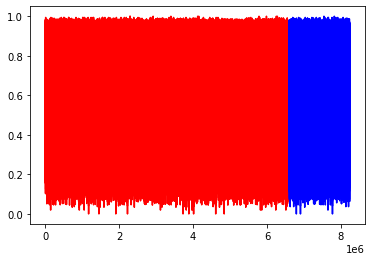

In [23]:
y1 = np.arange(1,X_train.shape[0]+1)
y2 = np.arange(X_train.shape[0],X_train.shape[0]+X_test.shape[0])

plt.plot(y1, X_train, 'r', y2, X_test, 'b')
plt.show()

In [24]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import layers
import keras

In [25]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)

In [26]:
X_train.shape

(6588056, 12, 1)

In [27]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=2)

Epoch 1/10
65881/65881 - 652s - loss: 3.4955e-04
Epoch 2/10
65881/65881 - 645s - loss: 3.3241e-04
Epoch 3/10
65881/65881 - 641s - loss: 3.2678e-04
Epoch 4/10
65881/65881 - 633s - loss: 3.2285e-04
Epoch 5/10
65881/65881 - 628s - loss: 3.2021e-04
Epoch 6/10
65881/65881 - 634s - loss: 3.1821e-04
Epoch 7/10
65881/65881 - 637s - loss: 3.1641e-04
Epoch 8/10
65881/65881 - 639s - loss: 3.1498e-04
Epoch 9/10
65881/65881 - 641s - loss: 3.1360e-04
Epoch 10/10
65881/65881 - 642s - loss: 3.1252e-04


In [39]:
loss = model.evaluate(X_train, y_train, verbose=0)
print(loss)

0.0003161664353683591


In [33]:
predictions = model.predict(X_test, verbose=2)
predictions = predictions.reshape(predictions.shape[0])
print(predictions.shape, y_test.shape)

51470/51470 - 90s
(1647014,) (1647014,)


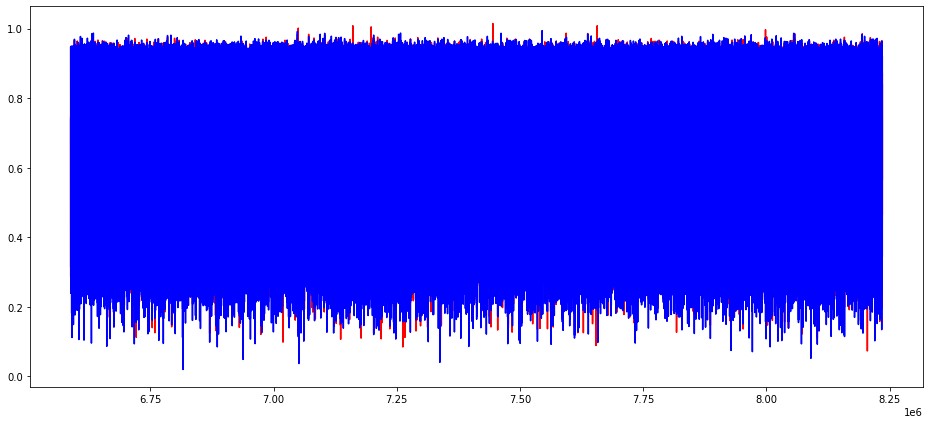

In [34]:
fig = plt.figure(figsize=(16, 7))
plt.plot(y2, predictions, 'r', y2, y_test, 'b')
plt.show()

In [35]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [36]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 12, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [37]:
predictions2 = regressor.predict(X_test, verbose=2)
predictions2 = predictions2.reshape(predictions.shape[0])

51470/51470 - 316s


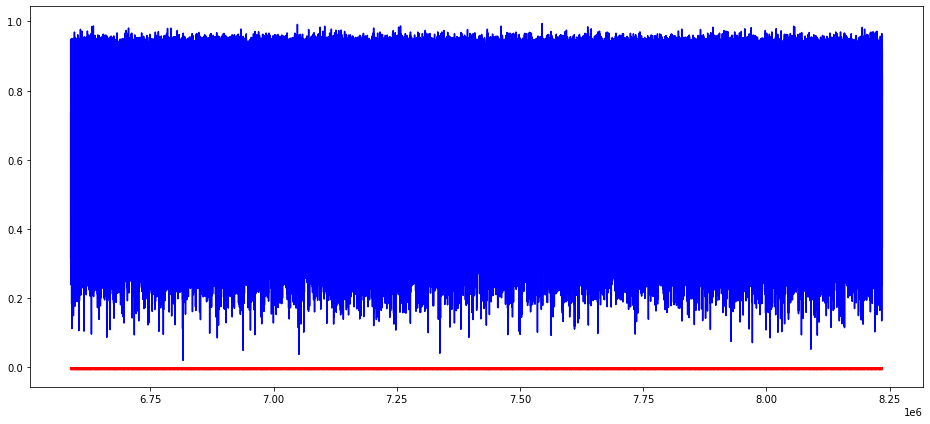

In [38]:
fig = plt.figure(figsize=(16, 7))
plt.plot(y2, predictions2, 'r', y2, y_test, 'b')
plt.show()